In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import layers

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load('tf_flowers', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True)

2023-02-01 23:42:35.826018: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /home/kaiky/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


2023-02-01 23:42:51.761696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-01 23:42:51.761732: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-01 23:42:51.761756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kaiky-Aspire-A315-56): /proc/driver/nvidia/version does not exist
2023-02-01 23:42:51.762161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
num_classes= metadata.features['label'].num_classes
print(num_classes)

5


2023-02-02 00:01:46.920753: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


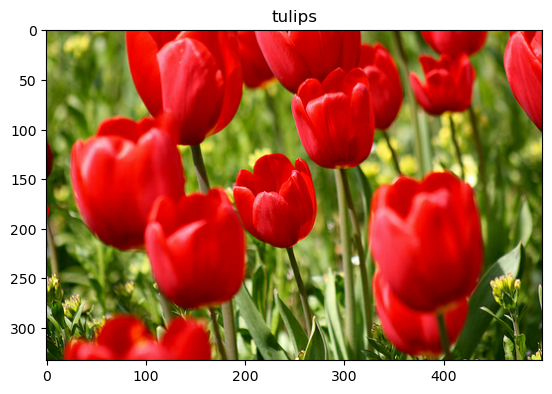

In [19]:
get_label_name = metadata.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

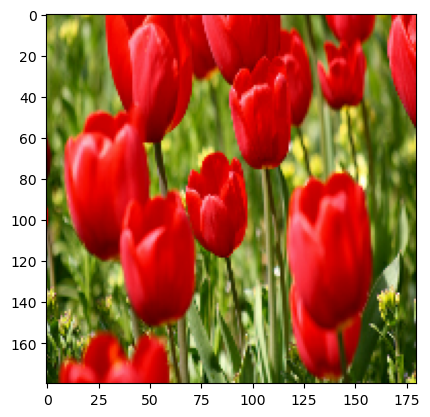

In [6]:
IMG_SIZE = 180

resize_and_rescale =  keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

result = resize_and_rescale(image)
_= plt.imshow(result)

In [7]:
print("Min and max pixel values: ", result.numpy().min(), result.numpy().max())

Min and max pixel values:  0.0 1.0


### Aumento de dados

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [17]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.image")


In [ ]:
# add the image to a batch
image = tf.expand_dims(image, 0)

plt.figure(figsize=(10,10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

### Existem duas maneiras de usar essas camadas de pré-processamento, com importantes compensações

Opção 1: tornar as camadas de pré-processamento parte do seu modelo:

In [ ]:
model = tf.keras.Sequential([
    # Add the preprocessing layers you created earlier.
    resize_and_rescale,
    data_augmentation, 
    layers.Conv2D(16,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # Rest of your model.
])


Há dois pontos importantes a serem observados neste caso:
</br>
<ul>O aumento de dados será executado no dispositivo, de forma síncrona com o restante de suas camadas e se beneficiará da aceleração da GPU.</ul>
<ul>Quando você exporta seu modelo usando model.save , as camadas de pré-processamento serão salvas junto com o restante do seu modelo. Se você implantar esse modelo posteriormente, ele padronizará automaticamente as imagens (de acordo com a configuração de suas camadas). Isso pode poupar você do esforço de ter que reimplementar essa lógica do lado do servidor.</ul>



Opção 2: aplique as camadas de pré-processamento ao seu conjunto de dados

In [ ]:
aug_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y))

Com essa abordagem, você usa Dataset.map para criar um conjunto de dados que produz lotes de imagens aumentadas. Nesse caso:

<ul>O aumento de dados acontecerá de forma assíncrona na CPU e não é bloqueante. Você pode sobrepor o treinamento do seu modelo na GPU com o pré-processamento de dados, usando Dataset.prefetch , mostrado abaixo.</ul>
<ul>Nesse caso, as camadas de pré-processamento não serão exportadas com o modelo quando você chamar Model.save . Você precisará anexá-los ao seu modelo antes de salvá-lo ou reimplementá-los no lado do servidor. Após o treinamento, você pode anexar as camadas de pré-processamento antes da exportação.</ul>

In [21]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle =False, augment = False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)
    
    ds = ds.batch(batch_size)
    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls = AUTOTUNE)
    
    return ds.prefetch(buffer_size = AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Treinar um modelo

In [22]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam', loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [25]:
epochs= 5
history = model.fit(
    train_ds,
    validation_data= val_ds,
    epochs= epochs
)

Epoch 1/5
92/92 [==============================] - 29s 278ms/step - loss: 1.4112 - accuracy: 0.4094 - val_loss: 1.2212 - val_accuracy: 0.5014
Epoch 2/5
92/92 [==============================] - 22s 231ms/step - loss: 1.1302 - accuracy: 0.5313 - val_loss: 1.0540 - val_accuracy: 0.5858
Epoch 3/5
92/92 [==============================] - 23s 239ms/step - loss: 1.0288 - accuracy: 0.5834 - val_loss: 1.0330 - val_accuracy: 0.5995
Epoch 4/5
92/92 [==============================] - 23s 239ms/step - loss: 0.9618 - accuracy: 0.6250 - val_loss: 1.0193 - val_accuracy: 0.5995
Epoch 5/5
92/92 [==============================] - 23s 239ms/step - loss: 0.9129 - accuracy: 0.6434 - val_loss: 0.9216 - val_accuracy: 0.6458


In [26]:
loss, acc= model.evaluate(test_ds)
print("Accuracy: ", acc)

12/12 [==============================] - 2s 122ms/step - loss: 0.8745 - accuracy: 0.6485
Accuracy:  0.6485013365745544


### Aumento de dados personalizados

Você também pode criar camadas de aumento de dados personalizadas.
</br>
Esta seção do tutorial mostra duas maneiras de fazer isso:
<ul>Primeiro, você criará uma camada tf.keras.layers.Lambda . Esta é uma boa maneira de escrever código conciso.</ul>
<ul>Em seguida, você escreverá uma nova camada via subclassing , o que lhe dará mais controle.</ul>
</br>
Ambas as camadas inverterão aleatoriamente as cores em uma imagem, de acordo com alguma probabilidade.




In [27]:
...

Ellipsis